In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from typing import Optional, List
from shapely.geometry import Polygon, Point, LineString
from ipywidgets import interact, FloatSlider, Label
from dataclasses import dataclass
import os
import warnings

# Suppress the specific warning
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Exercise 3: **Incidence Angles**

A terrain facet is given by three points:
a = $
\begin{bmatrix}
0\\ 0\\ 10 \end{bmatrix}
$ (center point), b = $
\begin{bmatrix}
5\\ 5\\ 15 \end{bmatrix}
$ and c = $
\begin{bmatrix}
-5\\ 5\\ 15 \end{bmatrix}
$ .

A radar satellite passes by this facet and measures a radar cross section $\sigma = 1.256\mathrm{m}^2$ with an across-track spatial resolution ($dR$) of 5m and an along-track spatial resolution ($dA_{az}$) of 10m. In this example it is assumed that the surface is a perfect scatterer and all measurements
only differ by the incidence angle. The measurements start at $x_s$ and continue as the satellite reaches the position $x_e$ (orbit direction follows $x$-axis):

$x_s = \begin{bmatrix} -2000\\ 0\\ 1000 \end{bmatrix}, x_e = \begin{bmatrix} +2000\\ 0\\ 1000 \end{bmatrix}$

First, transform $\sigma$ into a radar brightness value $\beta_0$. Then compute the incidence angle for each measurement, which takes place every 10m along the orbit path. You can determine the incidence angles by computing the angles between the surface normal and the surface-satellite vector.

Finally, transform the radar brightness into sigma nought ($\sigma_0$) and gamma nought ($\gamma_0$) for each incidence angle and plot the result.


## 3.1 What is the general relation between backscatter and incidence angles?

In general, the (general) incidence angle $\theta$ is defined as the polar angle, that is the angle between the ideal surface and its normal component. To take the topography into account and the deviations from an ideal surface, the angle $\alpha_i$ between the ideal surface and the superimposed topography at a given point $x_i$ is required to obtain the local incidence angle $\theta_i$:

$\theta_i = \theta - \alpha_i$


## 3.2 Explain the terms radar brightness, sigma nought and gamma nought.

The radar cross section $\sigma$ is related to a backscattering coefficient $\chi$ via:

$\mathrm{d}\sigma = \dfrac{\sigma}{\langle \mathrm{d}A \rangle} \mathrm{d}A = \chi \mathrm{d}A$

There are three backscatter coefficients:

-   **sigma naught/normalized radar cross section $\sigma^0$**: defined with respect to actually illuminated area
-   **gamma naught $\gamma^0$**: defined with respect to area perpendicular to $\vec{k}$
-   **beta naught/radar brightness $\beta^0$**: defined with respect to slant range, the 'geometric depth' along $\vec{k}$ for the topography-defined pixel $x_i$

The radar brightness $\beta^0$ is related to the radar cross section $\sigma$, range increment/cross-track spatial resolution $\mathrm{d}R$ and along-track spatial resolution $\mathrm{d}A_{az}$:

$\beta^0 = \dfrac{\sigma}{\langle A_{\beta} \rangle} = \dfrac{\sigma}{\langle \mathrm{d}R \cdot \mathrm{d}A_{az} \rangle}$.

Without further knowledge about the topography, only $\beta^0$ can be obtained. Otherwise, the normalized radar cross section and gamma naught are obtainable as:

$\sigma^0 = \beta^0 \cdot \sin\theta_i$

$\gamma^0 = \beta^0 \cdot \tan\theta_i$

As backscatter coefficients are usually given in units of decibel, this needs to be accounted for durign the calcualtions via:

$10\cdot\log\left(a\cdot b\right) = 10\cdot\log\left(a\right) + 10\cdot\log\left(b\right)$


## 3.3 Are there advantages of using a specific backscattering coefficient?

Differrent backscatter coefficients of course have a different meanin, but as they are all related to each other via simple geometric relations, there is no real advantage to any of them.


1. Compute the radar brightness in units of decibel from the radar cross section


In [2]:
SIGMA = 1.256  # m^2
RANGE_RES = 5  # m
AZIMUTHAL_RES = 10  #m

In [3]:
def beta_naught(sigma: float, dR: float, dA_az: float) -> float:
    """Calculate the beta naught value in decibel for a given sigma, dR, and dA_az.

    Parameters:
    ----------
    sigma : float
        The sigma value for the image, [m^2].
    dR : float
        The range resolution of the image, [m].
    dA_az : float
        The azimuth resolution of the image, [m].

    Returns:
    -------
    float
        The beta naught value for the given parameters, [dB].
    """
    return 10 * np.log10(sigma / (np.sqrt(dR**2 * dA_az**2)))


def gamma_naught(sigma: float, dR: float, dA_az: float,
                 theta_i: float) -> float:
    """Calculate the gamma naught value in decibel for a given beta naught and theta.

    Parameters:
    ----------
    sigma : float
        The sigma value for the image, [m^2].
    dR : float
        The range resolution of the image, [m].
    dA_az : float
        The azimuth resolution of the image, [m].
    theta_i : float
        The local angle of incidence, [rad].

    Returns:
    -------
    float
        The gamma naught value for the given parameters, [dB].
    """
    return beta_naught(sigma, dR, dA_az) + 10 * np.log10(np.tan(theta_i))


def sigma_naught(sigma: float, dR: float, dA_az: float,
                 theta_i: float) -> float:
    """Calculate the sigma naught value in decibel for a given beta naught and theta.

    Parameters:
    ----------
    sigma : float
        The sigma value for the image, [m^2].
    dR : float
        The range resolution of the image, [m].
    dA_az : float
        The azimuth resolution of the image, [m].
    theta_i : float
        The local angle of incidence, [rad].

    Returns:
    -------
    float
        The sigma naught value for the given parameters, [dB].
    """
    return beta_naught(sigma, dR, dA_az) + 10 * np.log10(np.sin(theta_i))

In [4]:
beta_0 = beta_naught(SIGMA, RANGE_RES, AZIMUTHAL_RES)
print(fr"beta_0 = {beta_0:.2f} dB")

beta_0 = -16.00 dB


2. Define the facet in 3D space


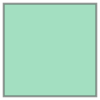

In [5]:
plane_p_a = np.array([0, 0, 10])
plane_p_b = np.array([5, 5, 15])
plane_p_c = np.array([-5, 5, 15])
plane_p_d = np.array([-5, -5, 5])
plane_p_e = np.array([5, -5, 5])

vertices = [plane_p_b, plane_p_c, plane_p_d, plane_p_e, plane_p_b]
facet = Polygon(vertices)

facet


Verify, that the center point _a_ is indeed contained in the plane


In [6]:
is_in_plane = facet.contains(Point(plane_p_a))
print(is_in_plane)


True


3. Calculate the normal vector to the facet. This is done by taking the cross product of the vectors containign the facet's vertices. Anchor the normal vector to the facet's center point. Normalization is omitted


In [7]:
normal_vector = np.cross(plane_p_d - plane_p_c, plane_p_b - plane_p_c)
normal_vector = np.array([plane_p_a, np.array(normal_vector)])
# normal_vector = np.array(normal_vector / np.linalg.norm(normal_vector))

normal_vector


array([[   0,    0,   10],
       [   0, -100,  100]])

4. Describe satellite track, assume a large curvature between points $x_s$ and $x_e$, thus the track is modeled using a vector (linear function). Then, compute all points contaiened in the satellite track, at a given interspacing of 10m


In [8]:
x_s = np.array([-2000, 0, 1000])
x_e = np.array([2000, 0, 1000])
satelite_track = LineString([x_s, x_e])
satelite_track.length
spacing = 10


def get_points_along_track(track, spacing):
    distance = 0
    points = []

    while distance <= track.length:
        point = track.interpolate(distance)
        x, y, z = point.coords[0]
        points.append(np.array([x, y, z]))
        distance += spacing

    return points


measurement_points = get_points_along_track(satelite_track, spacing)
measurement_points

[array([-2000.,     0.,  1000.]),
 array([-1990.,     0.,  1000.]),
 array([-1980.,     0.,  1000.]),
 array([-1970.,     0.,  1000.]),
 array([-1960.,     0.,  1000.]),
 array([-1950.,     0.,  1000.]),
 array([-1940.,     0.,  1000.]),
 array([-1930.,     0.,  1000.]),
 array([-1920.,     0.,  1000.]),
 array([-1910.,     0.,  1000.]),
 array([-1900.,     0.,  1000.]),
 array([-1890.,     0.,  1000.]),
 array([-1880.,     0.,  1000.]),
 array([-1870.,     0.,  1000.]),
 array([-1860.,     0.,  1000.]),
 array([-1850.,     0.,  1000.]),
 array([-1840.,     0.,  1000.]),
 array([-1830.,     0.,  1000.]),
 array([-1820.,     0.,  1000.]),
 array([-1810.,     0.,  1000.]),
 array([-1800.,     0.,  1000.]),
 array([-1790.,     0.,  1000.]),
 array([-1780.,     0.,  1000.]),
 array([-1770.,     0.,  1000.]),
 array([-1760.,     0.,  1000.]),
 array([-1750.,     0.,  1000.]),
 array([-1740.,     0.,  1000.]),
 array([-1730.,     0.,  1000.]),
 array([-1720.,     0.,  1000.]),
 array([-1710.

5. For each satellite track point, get the vector connecting it to the facet's center point


In [9]:
def get_vectors(point_on_plane, measurement_points):
    vectors = []
    for point in measurement_points:
        vectors.append([point_on_plane, point])
    return vectors


vectors = get_vectors(plane_p_a, [point for point in measurement_points])
vectors


[[array([ 0,  0, 10]), array([-2000.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1990.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1980.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1970.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1960.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1950.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1940.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1930.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1920.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1910.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1900.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1890.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1880.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1870.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1860.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1850.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-1840.,     0.,  1000.])],
 [array([ 0,  0, 10]), array([-

6. Calculate the angles between the normal vector and the facet-satellite track vectors (make sure they are anchored at the same point in space)


In [10]:
def get_angle(vector1: np.array, vector2: np.array):
    # Calculate the dot product
    dot_product = np.dot(vector1[1] - vector1[0], vector2[1] - vector2[0])

    # Calculate the magnitudes of the vectors
    magnitude1 = np.linalg.norm(vector1[1] - vector1[0])
    magnitude2 = np.linalg.norm(vector2[1] - vector2[0])

    return np.rad2deg(np.arccos(dot_product / (magnitude1 * magnitude2)))


facet_satellite_track_angles = [
    get_angle(normal_vector, vector) for vector in vectors
]
facet_satellite_track_angles

[72.73632036936303,
 72.66454580731373,
 72.59223439132998,
 72.51938094058598,
 72.44598022457596,
 72.37202696300261,
 72.29751582568696,
 72.22244143250116,
 72.14679835332527,
 72.07058110802954,
 71.99378416648372,
 71.91640194859474,
 71.83842882437452,
 71.75985911403936,
 71.68068708814288,
 71.60090696774415,
 71.52051292461294,
 71.439499081474,
 71.35785951229258,
 71.27558824260322,
 71.19267924988395,
 71.10912646397851,
 71.02492376756872,
 70.94006499669985,
 70.85454394136127,
 70.76835434612553,
 70.68148991084847,
 70.59394429143347,
 70.50571110066304,
 70.41678390910074,
 70.32715624606726,
 70.23682160069382,
 70.14577342305662,
 70.0540051253965,
 69.9615100834274,
 69.86828163773795,
 69.77431309529065,
 69.6795977310228,
 69.58412878955428,
 69.48789948700677,
 69.39090301293943,
 69.29313253240659,
 69.19458118814265,
 69.09524210288002,
 68.99510838180593,
 68.89417311516432,
 68.79242938100904,
 68.6898702481152,
 68.58648877905526,
 68.48227803344716,
 68.37

Optional: Visualize the angles calculated


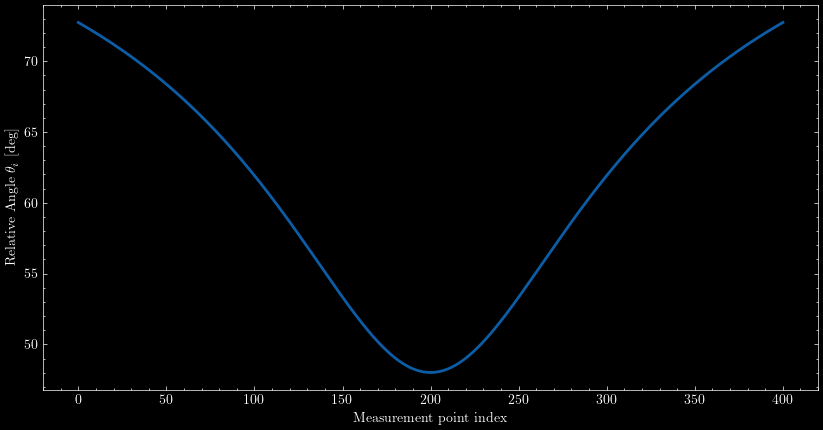

In [14]:
with plt.style.context("science"):

    plt.figure(1, figsize=(10, 5))
    plt.plot(facet_satellite_track_angles, linewidth=2)
    plt.ylabel(r'Relative Angle $\theta_i$ [$\deg$]')
    plt.xlabel('Measurement point index')

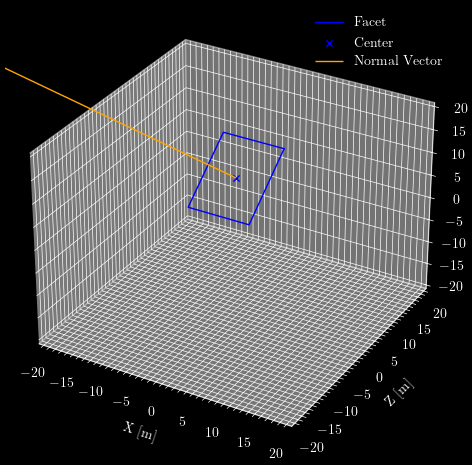

In [12]:
%matplotlib widget

# Create a 3D figure
fig = plt.figure(2)
plt.style.use('science')
ax = fig.add_subplot(111, projection='3d')

# Plot the facet
x, y, z = zip(*facet.exterior.coords)
ax.plot(x, y, z, color='blue', label='Facet')

# Plot the point_on_plane
ax.scatter(*plane_p_a,
           color='blue',
           marker='x',
           label='Center')

# Set the axis labels and title
ax.set_xlabel('X [m]')
ax.set_ylabel('Z [m]')
ax.set_zlabel('Y [m]')

# Add a legend
ax.legend()

ax.quiver(*normal_vector[0], *normal_vector[1],
          color='orange', label='Normal Vector')

# print(normal_vector.xy)

# Add the legend
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_zlim(-20, 20)

ax.legend()

# Adjust subplot parameters to remove white space
plt.tight_layout()

plt.show()


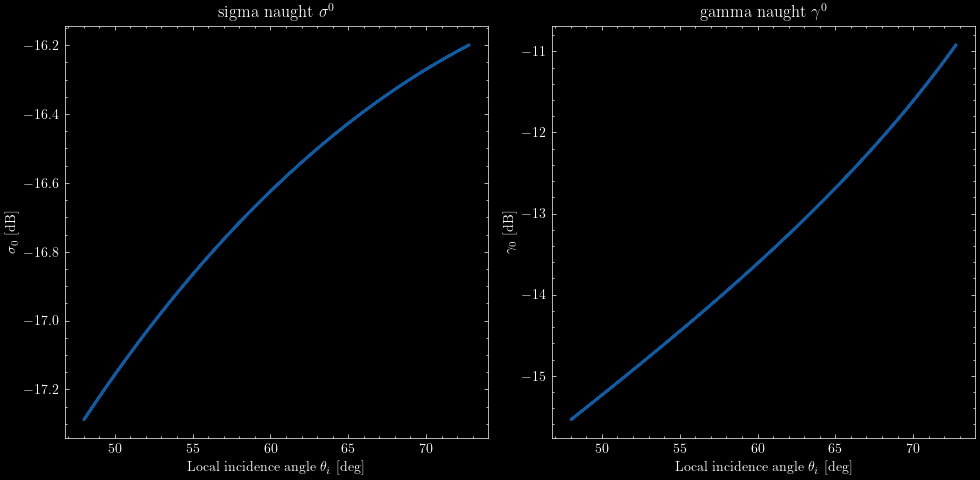

In [13]:
fig = plt.figure(3, figsize=(10, 5))
plt.style.use('science')

ax0 = fig.add_subplot(121)
ax0.plot(facet_satellite_track_angles,
         sigma_naught(SIGMA, RANGE_RES, AZIMUTHAL_RES,
                      np.deg2rad(facet_satellite_track_angles)),
         linewidth=2)

ax0.set_ylabel(r'$\sigma_0$ [dB]')
ax0.set_xlabel(r'Local incidence angle $\theta_i$ [deg]')
ax0.set_title(r'sigma naught $\sigma^0$')

ax1 = fig.add_subplot(122)
ax1.plot(facet_satellite_track_angles,
         gamma_naught(SIGMA, RANGE_RES, AZIMUTHAL_RES,
                      np.deg2rad(facet_satellite_track_angles)),
         linewidth=2)

ax1.set_ylabel(r'$\gamma_0$ [dB]')
ax1.set_xlabel(r'Local incidence angle $\theta_i$ [deg]')
ax1.set_title(r'gamma naught $\gamma^0$')

plt.tight_layout()
